# Data challenge - churn prevention for Revolut

## Prepare packages

We're reading below standard data science toolkit, including tools for data processing (e.g. `dask` - "pandas in parallel"), visualization tools (like e.g. `plotly`, `seaborn`) and some machine-learning frameworks (`scikit-learn`, and similar).

### System packages

In [1]:
import multiprocessing

In [2]:
import sys
import os

In [3]:
module_path = os.path.abspath(os.path.join('../code/'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Data science toolkit

In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### Machine learning

In [5]:
import featuretools as ft

### Visualizations

In [6]:
import seaborn as sns

In [40]:
import plotly.express as px

### Other

In [7]:
from pandas_profiling import ProfileReport

In [8]:
from rnormalize import normalize_user_id

In [43]:
from rtools import get_user_plan

## Read data

This Jupyter notebook follows rules of reproducible resarch, meaning it can be re-run (after preparing the environment, as defined in requirements.txt) - resulting in similar values in the output and exactly same business conclussions. The only requirement is to have the same file/dir structure - notebook should be located in the `notebooks` directory, above, we should have data in the `data` directory, and some additional sources in the `code` directory. 

### file location

In [9]:
devices_filename = '../data/rev-devices.csv'
notifications_filename = '../data/rev-notifications.csv'
users_filename = '../data/rev-users.csv'
transactions_filename = '../data/rev-transactions.csv'

### read csv files

In [10]:
devices = dd.read_csv(devices_filename)
f'File {devices_filename} was successfully read'

'File ../data/rev-devices.csv was successfully read'

In [11]:
notifications = dd.read_csv(notifications_filename)
f'File {notifications_filename} was successfully read'

'File ../data/rev-notifications.csv was successfully read'

In [12]:
users = dd.read_csv(users_filename)
f'File {users_filename} was successfully read'

'File ../data/rev-users.csv was successfully read'

In [13]:
transactions = dd.read_csv(transactions_filename)
f'File {transactions_filename} was successfully read'

'File ../data/rev-transactions.csv was successfully read'

## Data book

The objective of the Data Book is to provide useful `summaries of data`, which are easily understood by everyone.

1. table: **devices.csv**
   
   a table of devices associated with a user
     - brand​: string corresponding to the phone brand
     - user_id​: string uniquely identifying the user

2. table: **users.csv**

   a table of user data

    - user_id​: string uniquely identifying the user
    - birth_year​: integer corresponding to the user’s birth year
    - country​: two letter string corresponding to the user’s country of residence
    - city​: two string corresponding to the user’s city of residence
    - created_date​: datetime corresponding to the user’s created date
    - user_settings_crypto_unlocked​: integer indicating if the user has unlocked the crypto
    currencies in the app
    - plan​: string indicating on which plan the user is on
    - attributes_notifications_marketing_push​: float indicating if the user has accepted to receive
    marketing push notifications
    - attributes_notifications_marketing_email​: float indicating if the user has accepted to receive
    marketing email notifications
    - num_contacts​: integer corresponding to the number of contacts the user has on Revolut
    - num_referrals​: integer corresponding to the number of users referred by the selected user
    - num_successful_referrals​: integer corresponding to the number of users successfully
    referred by the selected user (successfully means users who have actually installed the app and are able to use the product)

3. table: **notifications.csv**

   a table of notifications that a user has received

    - reason​: string indicating the purpose of the notification
    - channel​: string indicating how the user has been notified
    - status​: string indicating the status of the notification
    - user_id​: string uniquely identifying the user
    - created_date​: datetime indicating when the notification has been sent

4. table: **transactions.csv**

   a table with transactions that a user made

    - transaction_id​: string uniquely identifying the transaction
    - transactions_type​: string indicating the type of the transaction
    - transactions_currency​: string indicating the currency of the transaction
    - amount_usd​: float corresponding to the transaction amount in USD
    - transactions_state​: string indicating the state of a transaction
    - COMPLETED - the transaction was completed and the user's balance was changed
    - DECLINED/FAILED - the transaction was declined for some reason, usually pertains to
    insufficient balance
    - REVERTED - the associated transaction was completed first but was then rolled back
    later in time potentially due to customer reaching out to Revolut
    - ea_cardholderpresence​: string indicating if the card holder was present when the transaction
    happened
    - ea_merchant_mcc​: float corresponding to the Merchant Category Code (MCC)
    - ea_merchant_city​: string corresponding to the merchant’s city
    - ea_merchant_country​: string corresponding to the merchant’s country
    - direction​: string indicating the direction of the transaction
    - user_id​: string uniquely identifying the user
    - created_date​: datetime corresponding to the transaction’s created date

## First glance at the data

We're checking here what's the size of data and how many columns we got

### Data volume

In [14]:
f'There are {devices.shape[0].compute()} rows in the "devices" table'

'There are 19430 rows in the "devices" table'

In [15]:
f'There are {notifications.shape[0].compute()} rows in the "notifications" table'

'There are 121813 rows in the "notifications" table'

In [16]:
f'There are {users.shape[0].compute()} rows in the "users" table'

'There are 19430 rows in the "users" table'

In [17]:
print(f'''There are {transactions.shape[0].compute()} rows in the "transactions" table. 
      The transactions table is {int(transactions.shape[0].compute() / users.shape[0].compute())} times bigger 
      than the number of users.''')

There are 2740075 rows in the "transactions" table. 
      The transactions table is 141 times bigger 
      than the number of users.


### Columns and their data types

In [18]:
devices.dtypes

brand      object
user_id    object
dtype: object

This is rather self-explanatory. It tells what type of device user is using (column - `brand`). 

In [19]:
notifications.dtypes

reason          object
channel         object
status          object
user_id         object
created_date    object
dtype: object

This is an interesting table. We're especially thrilling to investigate what type of messages are sent to the users (column - `reason`). Probably they're mostly "push" messages.

In [20]:
users.dtypes

user_id                                      object
birth_year                                    int64
country                                      object
city                                         object
created_date                                 object
user_settings_crypto_unlocked                 int64
plan                                         object
attributes_notifications_marketing_push     float64
attributes_notifications_marketing_email    float64
num_contacts                                  int64
num_referrals                                 int64
num_successful_referrals                      int64
dtype: object

Data on the user. We have information on the type of plan, as well as, some extra data about number of marketing messages. 

In [21]:
transactions.dtypes

transaction_id            object
transactions_type         object
transactions_currency     object
amount_usd               float64
transactions_state        object
ea_cardholderpresence     object
ea_merchant_mcc          float64
ea_merchant_city          object
ea_merchant_country       object
direction                 object
user_id                   object
created_date              object
dtype: object

Transactional data. It should be possible to find transaction type (atm/transfer/online), as well as country of the merchant. 

## Data profiling

### Users

In [22]:
users_df_profile = ProfileReport(users.sample(frac=0.25).compute(), 
                                 progress_bar=False,
                                 title='Pandas Profiling Report ("Users" dataframe)', 
                                 html={'style':{'full_width':True}})

In [23]:
users_df_profile.to_widgets()

In [24]:
users_df_profile.to_file(output_file="out/users_df_profile_p0.25.html")  # saving the whole report to an html file

### Devices

In [25]:
devices_df_profile = ProfileReport(devices.sample(frac=0.25).compute(), 
                                  progress_bar=False,
                                  title='Pandas Profiling Report ("Devices" dataframe)', 
                                  html={'style':{'full_width':True}})

In [26]:
devices_df_profile.to_widgets()

In [27]:
devices_df_profile.to_file(output_file="out/devices_df_profile_p0.25.html")

### Notifications

In [28]:
notifications_df_profile = ProfileReport(notifications.sample(frac=0.1).compute(), 
                                         progress_bar=False,
                                         title='Pandas Profiling Report ("Notifications" dataframe)', 
                                         html={'style':{'full_width':True}})

In [29]:
notifications_df_profile.to_widgets()

In [30]:
notifications_df_profile.to_file(output_file="out/notifications_df_profile_p0.10.html")

### Transactions

In [31]:
transactions_pd = transactions.compute()  # store df in memory

In [32]:
transactions_df_profile = ProfileReport(transactions_pd, 
                                        minimal=True,
                                        pool_size=multiprocessing.cpu_count()-1,
                                        title='Pandas Profiling Report ("Transactions" dataframe)', 
                                        html={'style':{'full_width':True}})

In [33]:
transactions_df_profile.to_widgets()

In [34]:
transactions_df_profile.to_file(output_file="out/transactions_df_profile_pALL.html")

## Data engineering

In [35]:
users_pd = users.compute()
users_pd['user_id'] = users_pd['user_id'].apply(lambda x: normalize_user_id(x)).astype(int)

In [36]:
devices_pd = devices.compute().reset_index().rename(columns={'index': 'device_id'})
devices_pd['user_id'] = devices_pd['user_id'].apply(lambda x: normalize_user_id(x)).astype(int)

In [52]:
notifications_pd = notifications.compute().reset_index().rename(columns={'index': 'notification_id'})
notifications_pd['user_id'] = notifications_pd['user_id'].apply(lambda x: normalize_user_id(x)).astype(int)

In [38]:
transactions_pd['user_id'] = transactions_pd['user_id'].apply(lambda x: normalize_user_id(x)).astype(int)

In [39]:
transactions_pd.memory_usage(deep=True)

Index                     21920600
transaction_id           207134590
transactions_type        182275087
transactions_currency    164404500
amount_usd                21920600
transactions_state       180410903
ea_cardholderpresence    134482025
ea_merchant_mcc           21920600
ea_merchant_city         141037387
ea_merchant_country      131953088
direction                177574595
user_id                   21920600
created_date             227426225
dtype: int64

## Exploratory data analysis

### Data understanding

Let's vizualize some data!

### Understanding notifications

In [56]:
notifications_pd.reason.value_counts()

REENGAGEMENT_ACTIVE_FUNDS               35844
FIFTH_PAYMENT_PROMO                     23743
NO_INITIAL_CARD_USE                     11221
NO_INITIAL_CARD_ORDER                   11136
METAL_GAME_START                         8373
LOST_CARD_ORDER                          6146
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER     5459
JOINING_ANNIVERSARY                      4158
MADE_MONEY_REQUEST_NOT_SPLIT_BILL        3506
ONBOARDING_TIPS_ACTIVATED_USERS          3145
ENGAGEMENT_SPLIT_BILL_RESTAURANT         2298
BLACK_FRIDAY                             2109
METAL_RESERVE_PLAN                       1233
PREMIUM_ENGAGEMENT_INACTIVE_CARD         1124
WELCOME_HOME                              950
PUMPKIN_PAYMENT_NOTIFICATION              690
PREMIUM_ENGAGEMENT_FEES_SAVED             678
Name: reason, dtype: int64

In [73]:
notifications_pd.channel.value_counts()

EMAIL    61253
PUSH     57683
SMS       2877
Name: channel, dtype: int64

The 'SMS' channel is used quite rarely, so we're going to omit it in our visualizations.

In [77]:
# notifications_plot_data = notifications_pd[notifications_pd.reason.isin(['REENGAGEMENT_ACTIVE_FUNDS',
#                                                                          'FIFTH_PAYMENT_PROMO',
#                                                                          'METAL_GAME_START',
#                                                                          'NO_INITIAL_CARD_USE',
#                                                                          'NO_INITIAL_CARD_ORDER'])].sample(n=1*1000)
notifications_plot_data = notifications_pd[notifications_pd.channel != 'SMS'].sample(n=30*1000)
notifications_plot_data['user_plan'] = notifications_pd['user_id'].apply(lambda x: get_user_plan(x, users_pd))
notifications_plot_data['total_notifications'] = 1

In [78]:
agg_notifications_plot_data = notifications_plot_data.groupby(['reason', 
                                                               'channel', 
                                                               'status', 
                                                               'user_plan']).agg({'total_notifications': 'sum'})

In [79]:
fig = px.bar(agg_notifications_plot_data.reset_index(), 
             x="reason", 
             y='total_notifications',
             color="user_plan", 
             barmode="stack",
             facet_row="channel", facet_col="status")
fig.show()

### Understanding transactions

In [85]:
transactions_pd

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,COMPLETED,FALSE,5814.0,Dubai,ARE,OUTBOUND,1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,COMPLETED,FALSE,5651.0,Abu Dhabi,ARE,OUTBOUND,5509,2019-03-22 05:42:50.316652
...,...,...,...,...,...,...,...,...,...,...,...,...
459322,transaction_2740070,TRANSFER,EUR,1.70,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,16319,2019-04-30 10:10:36.810961
459323,transaction_2740071,TRANSFER,EUR,17.02,COMPLETED,NaN,NaN,NaN,NaN,INBOUND,18233,2019-04-30 18:42:45.443443
459324,transaction_2740072,TRANSFER,EUR,4.26,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,13991,2019-05-01 11:34:25.078035
459325,transaction_2740073,TRANSFER,EUR,1.70,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,12529,2019-04-30 16:51:26.445105


In [98]:
transactions_for_plot = transactions_pd.sample(n=10*1000)
transactions_for_plot['amount_usd'] = transactions_for_plot['amount_usd'].apply(lambda x: np.log(x))

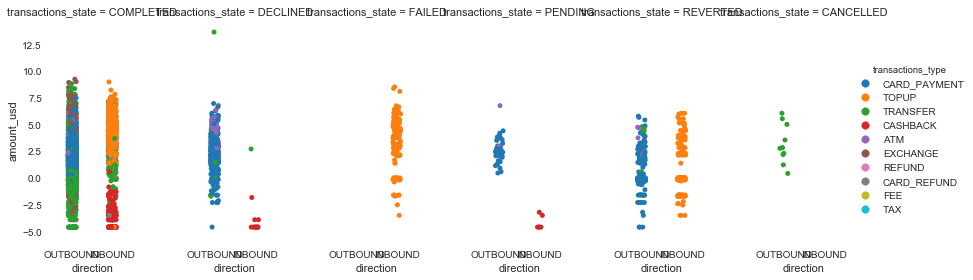

In [99]:
g = sns.catplot(x="direction", 
                y="amount_usd",
                hue="transactions_type", 
                col="transactions_state",
                data=transactions_for_plot, kind="strip",
                height=4, aspect=0.5)

## Feature engineering

### Define relations

In [ ]:
entities = {"users" : (users_pd, "user_id"),
            "devices" : (devices_pd, "device_id"),  # we really need that index-as-column 
            # https://github.com/FeatureLabs/featuretools/issues/130
            "notifications" : (notifications_pd, "notification_id"),
            "transactions": (transactions_pd, 'transaction_id'),
           }

In [ ]:
relationships = [("users", "user_id", "transactions", "user_id"),
                 ("users", "user_id", "notifications", "user_id"),
                 ("users", "user_id", "devices", "user_id")]

### Run deep feature synthesis

In [ ]:
feature_matrix_users, features_defs = ft.dfs(entities=entities,
                                             relationships=relationships,
                                             target_entity="users",  # we wish to profile users, so it's target
                                             # n_jobs=multiprocessing.cpu_count()-1,
                                             # I'm getting "zmq.error.ZMQError: Too many open files" - MacOS issue?
                                             verbose=True)

In [ ]:
features_defs

In [ ]:
feature_matrix_users

## Questions

### 1. Define a target metric to measure user engagement. 

#### How would you define an *engaged* vs. *unengaged* user?

Please provide the business justification and associated visualisations / rationale in choosing your definition of engagement.

#### Propose type of segments

Using my domain knowledge and an intuition (as an active Revolut user), I'd like to segment users into 3 segments:

1. **Super-commited users**

Users, who make transactions in their home country. They're not afraid to use Revolut on their daily basis, even for local ATMs and online purchases.

2. **Engaged users**

Users, who only make transactions abroad. Their main incentive is to save money on currency exchange spread. They're mostly people with non-premium subscriptions.

3. **Unengaged users**

Users, who don't make much tranactions, even when they're abroad. Low activity, low responsivness to marketing. 

It's practically impossible (with current state of data) to detect whenever the user goes abroad and doesn't use his/her Revolut actively there. While it's very easy to count number of transactions per country, this doesn't answer the question if the user went abroad (or not). Because of those facts, we're going to propose some other metric. Recently, customer loyalty has been measured by a metric called "RFV". Let's modify it by adding another dimension - response to "push" notifications. Such RFV(R) metric should be validated against 3 segments defined above (super-commited, engaged, unengaged) by adjusting importance weights. 

References:

https://www.intotheminds.com/blog/en/the-financial-times-found-the-most-perfect-kpis-to-measure-success/

* Recency – when did they last make a transaction?
* Frequency – how often do they make transactions?
* Volume – how many transactions have they made?
* Responsivity - how long it takes to make a transaction since last notification? 

#### Analyze type of distributions

#### Check for Pareto principle

#### Calculate Gini coefficient

### 2. Using your logic from above, build a model (heuristic/statistical/ML) to classify 'engaged' and 'unengaged' users

#### Note that features which are directly correlated with your target metric could lead to overfitting